<a href="https://colab.research.google.com/github/GazalaSayyad/GAN/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing required packages

In [0]:
import itertools
import math
import time
import matplotlib.pyplot as plt
from IPython import display

In [0]:
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

Load Data

In [0]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = dsets.MNIST(root='./data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)

Model


In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 784))
        out = out.view(out.size(0), -1)
        return out

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

Optimization

In [0]:
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

Training

In [0]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [0]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

Draw samples from the input distribution to inspect the generation on training 

In [0]:
num_test_samples = 16
test_noise = torch.randn(num_test_samples, 100).to(device)

Output image

Figure for plotting

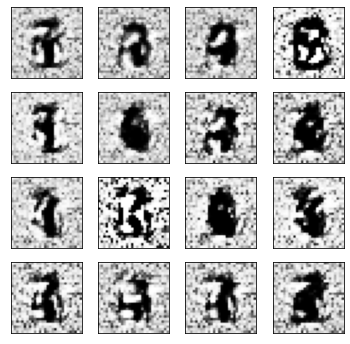

Epoch [38/50], Step[400/600], d_loss: 0.0284, g_loss: 8.3248, D(x): 0.99, D(G(z)): 0.01


In [0]:
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# set number of epochs and initialize figure counter
num_epochs = 50
num_batches = len(train_loader)
num_fig = 0


for epoch in range(num_epochs):
    for n, (images, _) in enumerate(train_loader):
        images = images.to(device)
        #print(images.size)
        real_labels = torch.ones(images.size(0)).to(device)
        
        # Sample from generator
        noise = torch.randn(images.size(0), 100).to(device)
        fake_images = generator(noise)
        fake_labels = torch.zeros(images.size(0)).to(device)
        
        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = torch.randn(images.size(0), 100).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)
        
        if (n+1) % 100 == 0:
            test_images = generator(test_noise)
            
            for k in range(num_test_samples):
                i = k//4
                j = k%4
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            plt.savefig('mnist-gan-%03d.png')
            num_fig += 1
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.item(), g_loss.item(),
                    real_score.data.mean(), fake_score.data.mean()))

fig.show()